Using backend: tensorflow.compat.v1

2021-12-12 13:52:27.498255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term




heat_1d_boundary_sin_exact: Average time with 15 tries: 0.0003 seconds
finite_difference_crank_nicolson: Average time with 15 tries: 0.0085 seconds


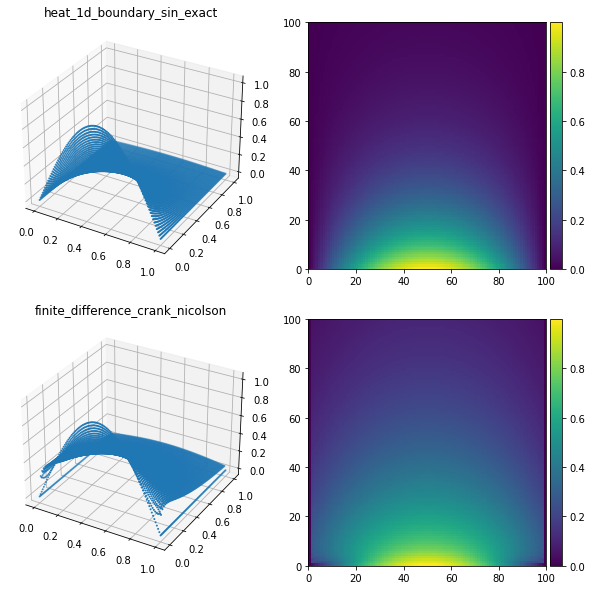

In [1]:
from dataclasses import dataclass

import numpy as np
import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import Plotter
from project.timer import Timer

TIMER_REPEAT_TIMES = 15

# Problem parameters:
@dataclass
class PinnConstParam:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar, Assum x starts at 0
    n = 1 # Frequency of the sinusoidal initial conditions
    t_end = 1 # Assume t_start  = 0
    test_x_dim = 100
    test_t_dim = 100
    analytical_function_name = "heat_1d_boundary_sin_exact"
    numerical_function_name = "finite_difference_crank_nicolson"
    X_test = None
    y_analytical = None
    y_numerical = None

@dataclass
class PinnTestParam:
    d_num_domain = 2540
    d_num_boundary = 80
    d_num_initial = 160
    nn_hidden_layer_size = 20
    nn_hidden_layer_num = 3

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - const_params.a*dy_xx

def create_model(const_params: PinnConstParam, test_params: PinnTestParam):
    # Computational geometry:
    geom = dde.geometry.Interval(0, const_params.L)
    timedomain = dde.geometry.TimeDomain(0, const_params.t_end)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(const_params.n*np.pi*x[:, 0:1]/const_params.L) , lambda _, on_initial: on_initial
        )

    geomtime_data = dde.data.TimePDE(
        geomtime, pde, [bc, ic],
        num_domain=test_params.d_num_domain,
        num_boundary=test_params.d_num_boundary,
        num_initial=test_params.d_num_initial,
        num_test=2540
    )

    nn_architecture = [2] + [test_params.nn_hidden_layer_size] * test_params.nn_hidden_layer_num + [1]
    net = dde.nn.FNN(
        nn_architecture,
        "tanh",
        "Glorot normal")

    model = dde.Model(geomtime_data, net)

    return geomtime_data, model

def train_model(model):
    # Build and train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    return losshistory, train_state

def plot_train_data(geomtime_data):
    X_bc_train = geomtime_data.bc_points()
    print("train_bc_points shape", X_bc_train.shape)

    plotter = Plotter(1, 2)
    plotter.plot_2d(X_bc_train, "train_bc_points")

    # Train points are not used anymore because deepxde train_points(),
    # always generate random train points, but it is not what we are doing to
    # train the nn, in train_next_batch(). train_next_batch, isnt random!!
    # X_train_points = geomtime_data.train_points()
    # print("train_points shape", X_train_points.shape)
    # plotter.plot_2d(X_train_points, "train_domain_points")

    X_train_next_batch, _, _ = geomtime_data.train_next_batch()
    print("train_next_batch shape", X_train_next_batch.shape)
    plotter.plot_2d(X_train_next_batch, "train_next_batch")

def plot_analytical_and_numerical(plotter, const_params: PinnConstParam):
    # I. Analytical test solution
        plotter.plot_2d_y(
            const_params.X_test,
            const_params.y_analytical,
            const_params.analytical_function_name)
        plotter.plot_2d_colormesh(
            const_params.y_analytical,
            const_params.test_x_dim,
            const_params.test_t_dim)

    # II. Numerical test solution
        plotter.plot_2d_y(
            const_params.X_test,
            const_params.y_numerical,
            const_params.numerical_function_name)
        plotter.plot_2d_colormesh(
            const_params.y_numerical,
            const_params.test_x_dim,
            const_params.test_t_dim)

def predict_and_output_report(const_params: PinnConstParam, model, losshistory = None, train_state = None):
    plotter = Plotter(3, 2)

    plot_analytical_and_numerical(plotter, const_params)

    # III. Physics Informed Neural Network test solution``
    function_name = "PINN prediction"
    ti = Timer(TIMER_REPEAT_TIMES)
    y_pred = ti.time_average(lambda : model.predict(const_params.X_test))
    print(function_name + ": "+ ti.str_average())
    plotter.plot_2d_y(const_params.X_test, y_pred, function_name)
    plotter.plot_2d_colormesh(
        y_pred,
        const_params.test_x_dim,
        const_params.test_t_dim)

    # Train loss, and Test data from PDE test data
    if losshistory and train_state:
        dde.saveplot(losshistory, train_state, issave=False, isplot=True)
        print("IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^")

    f = model.predict(const_params.X_test, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(const_params.y_analytical, y_pred))
    # np.savetxt("test.dat", np.hstack((X_test, y_analytical, y_pred)))

# Generate constants throughout this app!!
const_params = PinnConstParam()

ti = Timer(TIMER_REPEAT_TIMES)
const_params.X_test, const_params.y_analytical = ti.time_average(lambda : gen_data(
    const_params.analytical_function_name,
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim,
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }))
print(const_params.analytical_function_name + ": "+ ti.str_average())

X_test_num, const_params.y_numerical = ti.time_average(lambda : gen_data(
    const_params.numerical_function_name,
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim,
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }))
print(const_params.numerical_function_name + ": "+ ti.str_average())

plotter = Plotter(2, 2)
plot_analytical_and_numerical(plotter, const_params)

# Test 1: Default parameters from DeepXde

train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


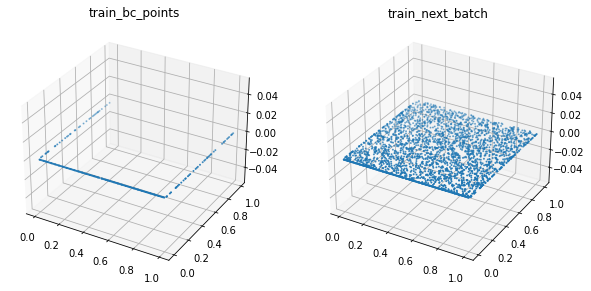

In [2]:
# Create model and plot training data
geomtime_data, model = create_model(const_params, PinnTestParam())
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.107093 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 13:52:29.927956: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-12 13:52:29.928567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-12 13:52:29.948466: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: un

'compile' took 0.290512 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.37e-02, 2.86e-03, 5.59e-01]    [1.37e-02, 2.86e-03, 5.59e-01]    []  


2021-12-12 13:52:30.116036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-12 13:52:30.136920: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3593250000 Hz


1000      [3.77e-04, 1.86e-04, 4.77e-05]    [2.98e-04, 1.86e-04, 4.77e-05]    []  
2000      [1.53e-04, 2.68e-05, 5.17e-06]    [1.10e-04, 2.68e-05, 5.17e-06]    []  
3000      [8.87e-05, 9.98e-06, 5.00e-07]    [6.20e-05, 9.98e-06, 5.00e-07]    []  
4000      [6.23e-05, 1.01e-05, 1.24e-05]    [4.69e-05, 1.01e-05, 1.24e-05]    []  
5000      [4.49e-05, 6.33e-06, 9.15e-06]    [3.34e-05, 6.33e-06, 9.15e-06]    []  
6000      [3.57e-05, 2.63e-06, 4.12e-07]    [2.39e-05, 2.63e-06, 4.12e-07]    []  
7000      [2.58e-05, 1.26e-06, 2.70e-07]    [1.83e-05, 1.26e-06, 2.70e-07]    []  
8000      [5.62e-05, 3.52e-06, 3.19e-05]    [3.94e-05, 3.52e-06, 3.19e-05]    []  
9000      [3.06e-05, 3.23e-06, 2.23e-07]    [1.99e-05, 3.23e-06, 2.23e-07]    []  
10000     [1.16e-04, 8.87e-06, 8.61e-06]    [8.21e-05, 8.87e-06, 8.61e-06]    []  
11000     [4.21e-05, 3.03e-06, 2.26e-06]    [2.91e-05, 3.03e-06, 2.26e-06]    []  
12000     [1.05e-05, 3.58e-07, 7.21e-08]    [7.34e-06, 3.58e-07, 7.21e-08]    []  
1300

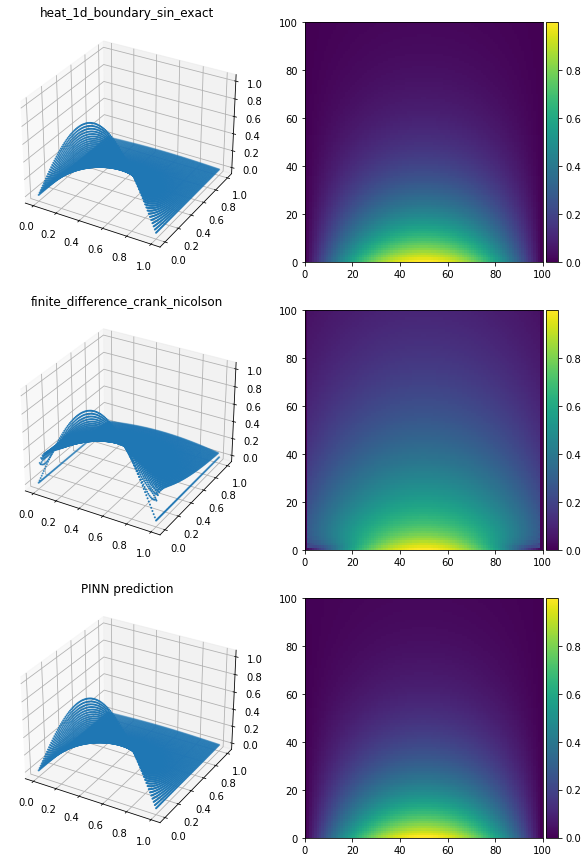

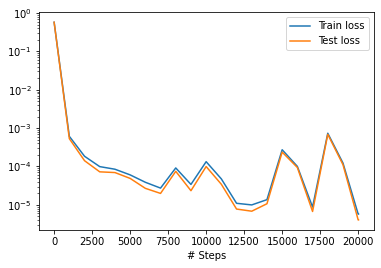

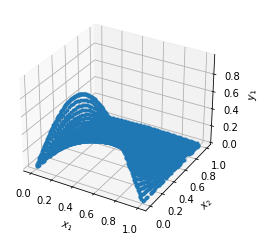

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0014898923
L2 relative error: 0.0015606018437587074


In [3]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 2: Reduce hidden layers and size to break solution

In [4]:
test_params = PinnTestParam()
test_params.nn_hidden_layer_num = 1
test_params.nn_hidden_layer_size = 5

geomtime_data, model = create_model(const_params, test_params)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


Compiling model...
Building feed-forward neural network...
'build' took 0.015963 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 13:53:36.425239: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.126195 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.08e-02, 1.96e-01, 2.78e-01]    [6.98e-02, 1.96e-01, 2.78e-01]    []  
1000      [9.05e-03, 3.60e-02, 7.61e-02]    [7.14e-03, 3.60e-02, 7.61e-02]    []  
2000      [7.32e-03, 3.16e-02, 4.37e-02]    [5.99e-03, 3.16e-02, 4.37e-02]    []  
3000      [8.82e-03, 2.61e-02, 3.73e-02]    [7.29e-03, 2.61e-02, 3.73e-02]    []  
4000      [1.05e-02, 2.03e-02, 3.08e-02]    [8.55e-03, 2.03e-02, 3.08e-02]    []  
5000      [1.41e-02, 1.38e-02, 2.44e-02]    [1.12e-02, 1.38e-02, 2.44e-02]    []  
6000      [1.48e-02, 1.21e-02, 2.17e-02]    [1.17e-02, 1.21e-02, 2.17e-02]    []  
7000      [1.48e-02, 1.11e-02, 1.97e-02]    [1.16e-02, 1.11e-02, 1.97e-02]    []  
8000      [1.55e-02, 6.03e-03, 1.35e-02]    [1.14e-02, 6.03e-03, 1.35e-02]    []  
9000      [1.08e-02, 2.29e-03, 7.45e-03]    [7.76e-03, 2.29e-03, 7.45e-03]    []  
10000   

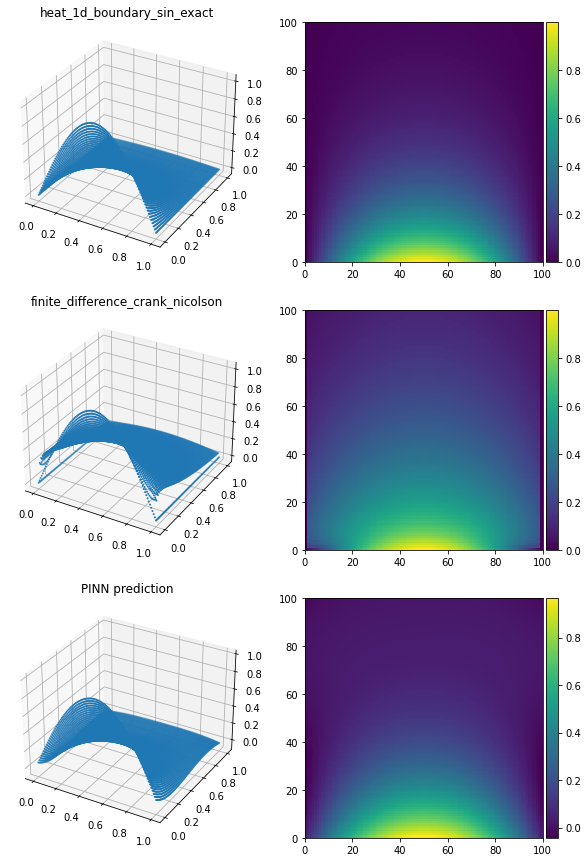

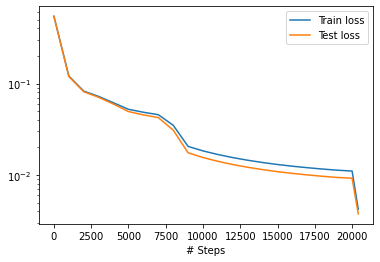

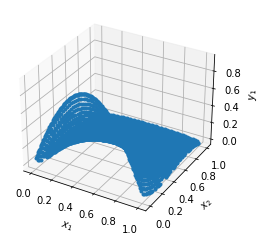

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.04256595
L2 relative error: 0.05935259670289663


In [5]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 3: Reduce boundary points to break solution

train_bc_points shape (6, 2)
train_next_batch shape (2552, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "


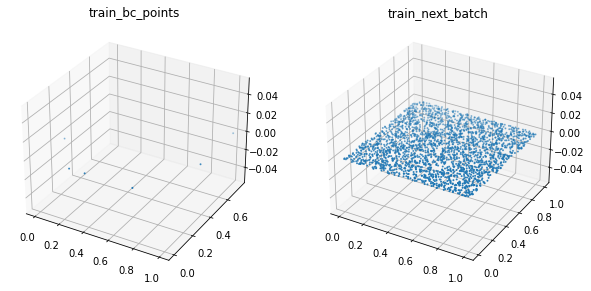

In [6]:
test_params = PinnTestParam()
test_params.d_num_boundary = 3
test_params.d_num_initial = 3

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.028548 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 13:53:55.439125: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.222039 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.03e+00, 5.02e-01, 4.07e-01]    [1.03e+00, 5.02e-01, 4.07e-01]    []  
1000      [5.83e-04, 5.76e-03, 3.27e-03]    [4.34e-04, 5.76e-03, 3.27e-03]    []  
2000      [5.91e-04, 3.43e-04, 1.03e-03]    [4.73e-04, 3.43e-04, 1.03e-03]    []  
3000      [2.16e-04, 2.64e-06, 4.78e-04]    [1.57e-04, 2.64e-06, 4.78e-04]    []  
4000      [1.21e-04, 3.61e-06, 1.57e-04]    [8.36e-05, 3.61e-06, 1.57e-04]    []  
5000      [7.23e-05, 4.58e-06, 4.00e-05]    [5.03e-05, 4.58e-06, 4.00e-05]    []  
6000      [4.46e-05, 7.58e-06, 2.11e-05]    [3.20e-05, 7.58e-06, 2.11e-05]    []  
7000      [2.91e-05, 1.89e-08, 3.13e-06]    [2.15e-05, 1.89e-08, 3.13e-06]    []  
8000      [2.09e-05, 4.33e-08, 1.51e-06]    [1.57e-05, 4.33e-08, 1.51e-06]    []  
9000      [2.48e-05, 6.28e-07, 9.23e-07]    [2.13e-05, 6.28e-07, 9.23e-07]    []  
10000   

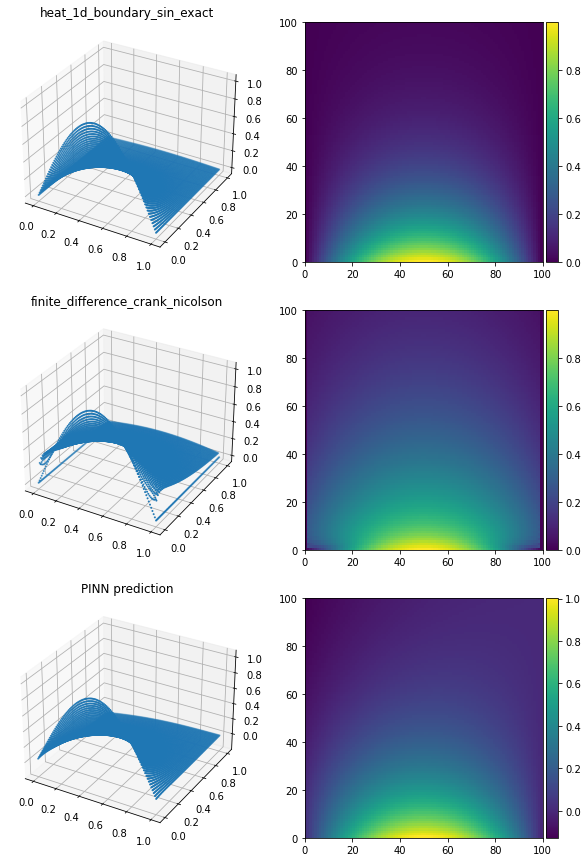

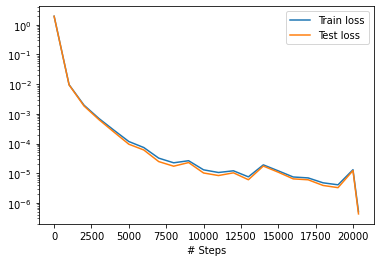

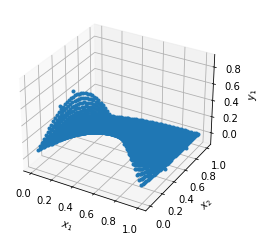

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.00054915476
L2 relative error: 0.13399302555722614


In [7]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)

# Test 4: Reduce domain to break solution

train_bc_points shape (240, 2)
train_next_batch shape (530, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


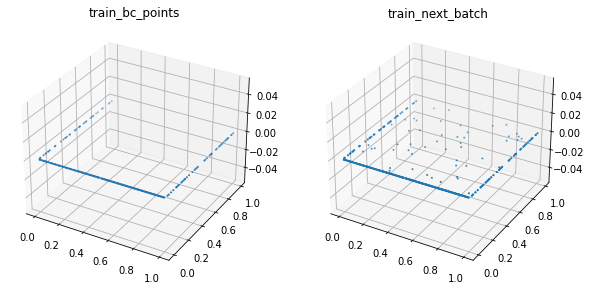

In [8]:
test_params = PinnTestParam()
test_params.d_num_domain = 50

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.032175 s



2021-12-12 13:54:52.241309: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.247405 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.28e-02, 3.17e-02, 4.11e-01]    [1.79e-02, 3.17e-02, 4.11e-01]    []  
1000      [1.47e-03, 8.86e-04, 5.41e-04]    [3.97e-03, 8.86e-04, 5.41e-04]    []  
2000      [3.17e-04, 7.48e-05, 6.04e-05]    [1.89e-03, 7.48e-05, 6.04e-05]    []  
3000      [1.72e-04, 3.96e-05, 2.95e-05]    [9.52e-04, 3.96e-05, 2.95e-05]    []  
4000      [1.23e-04, 1.90e-05, 1.64e-05]    [6.66e-04, 1.90e-05, 1.64e-05]    []  
5000      [9.14e-05, 8.99e-06, 9.27e-06]    [5.06e-04, 8.99e-06, 9.27e-06]    []  
6000      [6.81e-05, 4.50e-06, 5.79e-06]    [4.12e-04, 4.50e-06, 5.79e-06]    []  
7000      [5.19e-05, 2.41e-06, 3.48e-06]    [3.55e-04, 2.41e-06, 3.48e-06]    []  
8000      [2.27e-04, 6.60e-06, 1.67e-05]    [4.06e-04, 6.60e-06, 1.67e-05]    []  
9000      [3.41e-05, 9.58e-07, 1.53e-06]    [3.02e-04, 9.58e-07, 1.53e-06]    []  
10000   

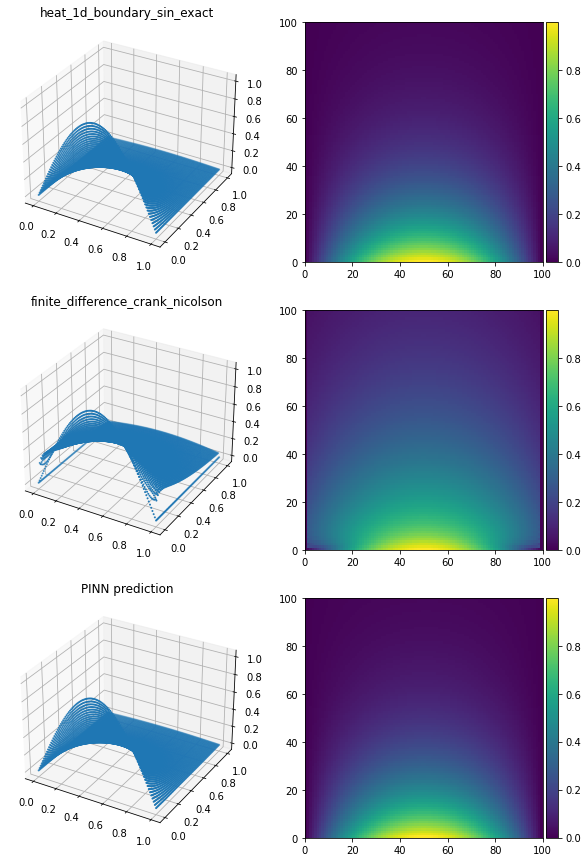

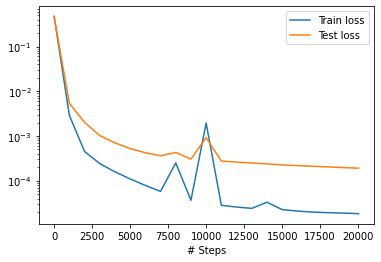

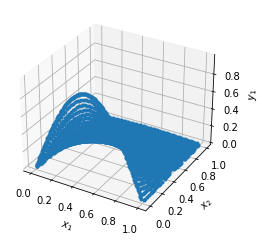

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.009073062
L2 relative error: 0.00288457017139941


In [9]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 5: Reduce train data (domain and bc) to break solution

train_bc_points shape (20, 2)
train_next_batch shape (90, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "


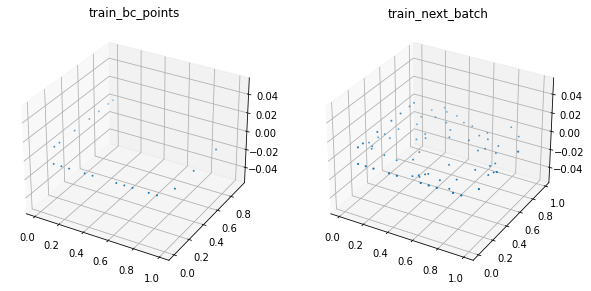

In [10]:
test_params = PinnTestParam()
test_params.d_num_domain = 50
test_params.d_num_boundary = 10
test_params.d_num_initial = 10

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.028305 s



2021-12-12 13:55:15.998503: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.232488 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.63e-01, 1.35e-01, 2.74e-01]    [1.50e-01, 1.35e-01, 2.74e-01]    []  
1000      [1.57e-03, 1.58e-03, 1.92e-03]    [1.26e-03, 1.58e-03, 1.92e-03]    []  
2000      [2.26e-04, 3.83e-05, 3.08e-05]    [6.14e-04, 3.83e-05, 3.08e-05]    []  
3000      [1.03e-04, 2.68e-05, 1.45e-05]    [1.92e-04, 2.68e-05, 1.45e-05]    []  
4000      [3.27e-05, 9.57e-06, 3.94e-06]    [1.01e-04, 9.57e-06, 3.94e-06]    []  
5000      [1.86e-05, 5.89e-06, 2.84e-06]    [8.26e-05, 5.89e-06, 2.84e-06]    []  
6000      [1.28e-05, 4.44e-06, 2.46e-06]    [7.83e-05, 4.44e-06, 2.46e-06]    []  
7000      [8.56e-06, 2.73e-06, 1.76e-06]    [7.60e-05, 2.73e-06, 1.76e-06]    []  
8000      [7.05e-06, 2.04e-06, 1.44e-06]    [7.20e-05, 2.04e-06, 1.44e-06]    []  
9000      [7.77e-06, 1.74e-06, 1.28e-06]    [7.09e-05, 1.74e-06, 1.28e-06]    []  
10000   

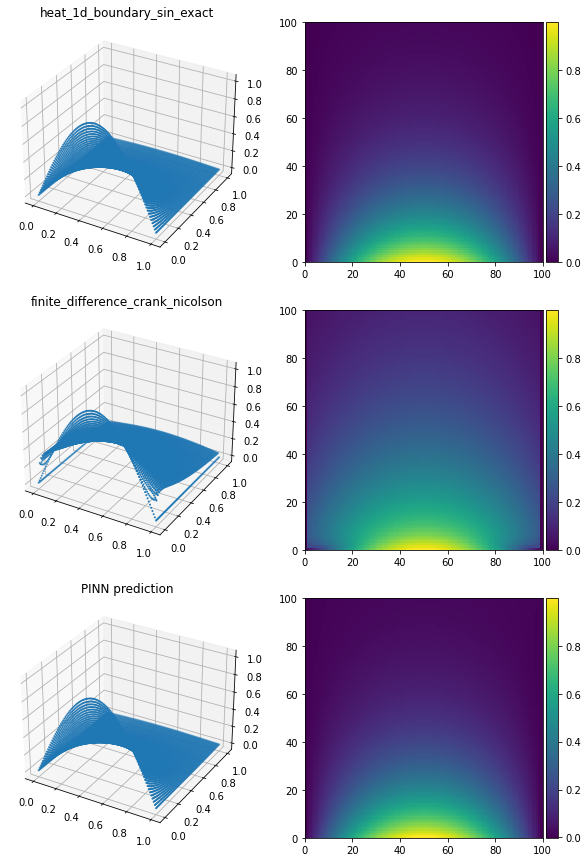

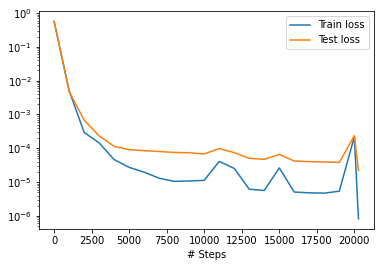

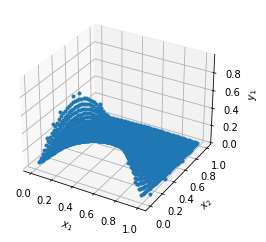

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0023484097
L2 relative error: 0.002627910740544408


In [11]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)
